## Лабораторная работа №7
#### По дисциплине "численные методы"
Выполнил: Гаврилов М.С.  
Группа: М8О-406Б-19  
Вариант: 7

In [5]:
import numpy as np
import pylab
import copy
from tqdm import tqdm

In [206]:
def visualise(matr,t_skip,shape = [1,1]):
    pylab.figure(figsize = (shape[0],shape[1]))
    pylab.xlabel("x")
    pylab.ylabel("y")
    for i in range(matr.shape[0]):
        if(i % t_skip != 0):
            continue
            
        for j in range(matr.shape[1]):
            
            if(matr[i][j] > 0):
                pylab.plot(j,i,'s',color = (matr[i][j],0,0))
            if(matr[i][j] <= 0):
                pylab.plot(j,i,'s',color = (0,0,-matr[i][j]))
    pylab.show()

In [169]:
class mesh():
    def __init__(self,x_resolution,y_resolution,x_span,y_span,approx_method = 0):
        self.type = None
        self.approx = approx_method
        #approx_method - метод аппроксимации, используемый при наличии производных на границе
        #0 - двуточечный  1-го порядка
        #1 - двуточечный  2-го порядка
        #41 - терхточечный 2-го порядка
        #для рассчета первого слоя используетля 
        #0 - двухточечный первого порядка
        #other - двухточечный второго порядка
        
        self.x_resolution = x_resolution
        self.y_resolution = y_resolution
        self.x_span = x_span
        self.y_span = y_span
        
        #заполнение координат узлов сетки
        self.mesh_nodes = np.zeros([x_resolution,y_resolution,2])
        x = (x_span[1] - x_span[0])/(x_resolution-1)
        y = (y_span[1] - y_span[0])/(y_resolution-1)
        self.x = x
        self.y = y
        
        #заполнение значений узлов сетки
        for i in np.arange(y_resolution):
            for j in np.arange(x_resolution):
                self.mesh_nodes[i,j,0] = i*y
                self.mesh_nodes[i,j,1] = j*x
                
        self.mesh_nodes_value = np.zeros([y_resolution,x_resolution])
                
        
    def set_border_val(self,fx0,fxl,fy0,fyl):
        for i in range(self.y_resolution):
            self.mesh_nodes_value[i,0] = fx0(self.mesh_nodes[i,0,0])
            self.mesh_nodes_value[i,self.x_resolution - 1] = fxl(self.mesh_nodes[i,self.x_resolution - 1,0])
            
        for i in range(self.x_resolution):
            self.mesh_nodes_value[0,i] = fy0(self.mesh_nodes[0,i,1])
            self.mesh_nodes_value[self.y_resolution - 1,i] = fyl(self.mesh_nodes[self.y_resolution - 1,i,1])
            
        self.type = 1
        
    def set_mesh_values(self,vals):
        
        for i in range(self.y_resolution):
            for j in range(0, self.x_resolution):
                self.mesh_nodes_value[i,j] = vals(self.mesh_nodes[i,j])
                
  
    def Solve_Libman(self,a,f = None,lim_iteraions = 100,eps = 0.0001):
        
        for k in range(lim_iteraions):
            next_layer = copy.deepcopy(self.mesh_nodes_value)
            for i in range(1,self.y_resolution-1):
                for j in range(1,self.x_resolution-1):
                    next_layer[i,j] = self.mesh_nodes_value[i,j-1] + self.mesh_nodes_value[i,j+1] + self.mesh_nodes_value[i+1,j] + self.mesh_nodes_value[i-1,j]
                    if(f != None):
                        next_layer[i,j] -= self.x*self.y*f(self.mesh_nodes[i,j])
                        
                    next_layer[i,j] = next_layer[i,j]/(4-a*self.x*self.y)
            
            if(eps != None and np.max(np.abs(next_layer - self.mesh_nodes_value)) < eps):
                return k

            self.mesh_nodes_value = copy.deepcopy(next_layer)
            
        return k 
            
    def Solve_Seidel(self,a,f = None,lim_iteraions = 100,eps = 0.0001):
        #использует уже посчитанные значения с нового слоя
        
        for k in range(lim_iteraions):
            next_layer = copy.deepcopy(self.mesh_nodes_value)
            
            for i in range(1,self.y_resolution-1):
                for j in range(1,self.x_resolution-1):
                    next_layer[i,j] = next_layer[i,j-1] + next_layer[i,j+1] + next_layer[i+1,j] + next_layer[i-1,j]
                    if(f != None):
                        next_layer[i,j] -= self.x*self.y*f(self.mesh_nodes[i,j])
                        
                    next_layer[i,j] = next_layer[i,j]/(4-a*self.x*self.y)
                    
            if(eps != None and np.max(np.abs(next_layer - self.mesh_nodes_value)) < eps):
                return k
            
            self.mesh_nodes_value = copy.deepcopy(next_layer)
            
        return k 
    
    
    def Solve_IUR(self,a, w, f = None, lim_iteraions = 100, eps = 0.0001):
        if(w > 2 or w < 1):
            return
        
        for k in range(a,lim_iteraions):
            next_layer = copy.deepcopy(self.mesh_nodes_value)
            
            for i in range(1,self.y_resolution-1):
                for j in range(1,self.x_resolution-1):
                    next_layer[i,j] = next_layer[i,j-1] + next_layer[i,j+1] + next_layer[i+1,j] + next_layer[i-1,j]
                    if(f != None):
                        next_layer[i,j] -= self.x*self.y*f(self.mesh_nodes[i,j])
                        
                    next_layer[i,j] = (1 - w)*self.mesh_nodes_value[i,j] + (w)*(next_layer[i,j]/(4-a*self.x*self.y))
            
            if(eps != None and np.max(np.abs(next_layer - self.mesh_nodes_value)) < eps):
                return k
            
            self.mesh_nodes_value = copy.deepcopy(next_layer)
            
        return k 
    
    
    def print(self,skip = 1):
        vis_mesh = self.mesh_nodes_value / np.max(np.abs(self.mesh_nodes_value))
        visualise(vis_mesh,t_skip = skip,shape = [self.x_span[1] - self.x_span[0],self.y_span[1] - self.y_span[0]])
        
    def compare(self,other):
        return np.mean(np.abs(self.mesh_nodes_value - other.mesh_nodes_value))
        
    def compare_verbal(self,other,skip = 10):
        print("mean abs error: {}".format(np.mean(np.abs(self.mesh_nodes_value - other.mesh_nodes_value))))
        print("error map:")
        dif_mesh = (self.mesh_nodes_value - other.mesh_nodes_value)
        dif_mesh = dif_mesh / np.max(np.abs(dif_mesh))
        visualise(dif_mesh,t_skip = skip,shape = [self.x_span[1] - self.x_span[0],self.y_span[1] - self.y_span[0]])
        
        return np.mean(np.abs(self.mesh_nodes_value - other.mesh_nodes_value))
    
    def compare_by_layers(self,other,skip = 10):
        arr = []
        for i in range(0,len(self.mesh_nodes_value),skip):
                arr.append([i,np.mean(np.abs(self.mesh_nodes_value[i] - other.mesh_nodes_value[i])),np.mean((self.mesh_nodes_value[i] - other.mesh_nodes_value[i]))])
        arr = np.array(arr)
        
        pylab.figure(figsize = (8,5))
        pylab.xlabel("temporal layer",color = "grey")
        pylab.ylabel("mean error at layer",color = "grey")
            
        pylab.xlim([0,len(self.mesh_nodes_value)])
        
        pylab.plot(arr[:,0],arr[:,1],label = "abs error")
        pylab.plot(arr[:,0],arr[:,2],label = "no abs error")
        pylab.legend()
        pylab.show()
        

In [207]:
def X0(y):
    return np.cos(y)
def Xl(y):
    return 0
def Y0(x):
    return np.cos(x)
def Yl(x):
    return 0

In [208]:
def sol(inp):
    y,x = inp
    return np.cos(x)*np.cos(y)

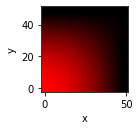

In [209]:
test_mesh = mesh(50,50,[0,np.pi/2],[0,np.pi/2])
test_mesh.set_border_val(X0,Xl,Y0,Yl)
test_mesh.set_mesh_values(sol)
test_mesh.print()

#### Метод Либмана

solved in 1561 iterations


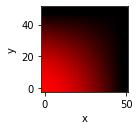

In [210]:
lib_mesh = mesh(50,50,[0,np.pi/2],[0,np.pi/2])
lib_mesh.set_border_val(X0,Xl,Y0,Yl)
k = lib_mesh.Solve_Libman(2,lim_iteraions = 2000,eps = 1e-4)
print("solved in {} iterations".format(k))
lib_mesh.print()

mean abs error: 0.025194735751931874
error map:


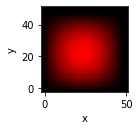

In [211]:
lib_error = test_mesh.compare_verbal(lib_mesh,skip=1)

#### Метод Зейделя

solved in 992 iterations


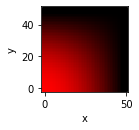

In [212]:
Seidel_mesh = mesh(50,50,[0,np.pi/2],[0,np.pi/2])
Seidel_mesh.set_border_val(X0,Xl,Y0,Yl)
k = Seidel_mesh.Solve_Seidel(2,lim_iteraions = 2000,eps = 1e-4)
print("solved in {} iterations".format(k))
Seidel_mesh.print()

mean abs error: 0.012591197456895763
error map:


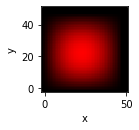

In [213]:
Seidel_error = test_mesh.compare_verbal(Seidel_mesh,skip=1)

#### Метод простой итерации с верхней релаксацией

w = 1.5

solved in 441 iterations


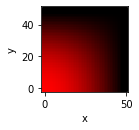

In [214]:
IUR_mesh = mesh(50,50,[0,np.pi/2],[0,np.pi/2])
IUR_mesh.set_border_val(X0,Xl,Y0,Yl)
k = IUR_mesh.Solve_IUR(2,w = 1.5,lim_iteraions = 2000,eps = 1e-4)
print("solved in {} iterations".format(k))
IUR_mesh.print()

mean abs error: 0.004170546483655248
error map:


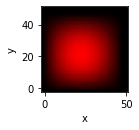

In [215]:
IUR_error = test_mesh.compare_verbal(IUR_mesh,skip=1)

w = 1.9

solved in 94 iterations


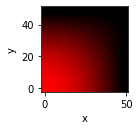

In [216]:
IUR_mesh = mesh(50,50,[0,np.pi/2],[0,np.pi/2])
IUR_mesh.set_border_val(X0,Xl,Y0,Yl)
k = IUR_mesh.Solve_IUR(2,w = 1.9,lim_iteraions = 2000,eps = 1e-4)
print("solved in {} iterations".format(k))
IUR_mesh.print()

mean abs error: 2.67028304542239e-05
error map:


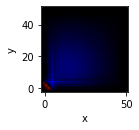

In [217]:
IUR_error = test_mesh.compare_verbal(IUR_mesh,skip=1)

w = 1.95

solved in 178 iterations


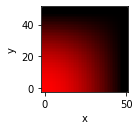

In [218]:
IUR_mesh = mesh(50,50,[0,np.pi/2],[0,np.pi/2])
IUR_mesh.set_border_val(X0,Xl,Y0,Yl)
k = IUR_mesh.Solve_IUR(2,w = 1.95,lim_iteraions = 2000,eps = 1e-4)
print("solved in {} iterations".format(k))
IUR_mesh.print()

mean abs error: 9.879087641317382e-06
error map:


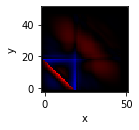

In [219]:
IUR_error = test_mesh.compare_verbal(IUR_mesh,skip=1)

w = 2

solved in 1999 iterations


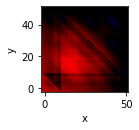

In [220]:
IUR_mesh = mesh(50,50,[0,np.pi/2],[0,np.pi/2])
IUR_mesh.set_border_val(X0,Xl,Y0,Yl)
k = IUR_mesh.Solve_IUR(2,w = 2,lim_iteraions = 2000,eps = 1e-4)
print("solved in {} iterations".format(k))
IUR_mesh.print()

mean abs error: 0.17831219950983396
error map:


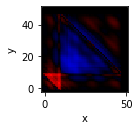

In [221]:
IUR_error = test_mesh.compare_verbal(IUR_mesh,skip=1)

### Исследование зависимости скоростей сходиости методов от параметров сетки

##### Исследование зависимости ошибки от числа итераций

In [197]:
arr = []
for i in tqdm(range(10,3000,100)):
    
    ril_mesh = mesh(50,50,[0,np.pi/2],[0,np.pi/2])
    ril_mesh.set_mesh_values(sol)

    
    lib_mesh = mesh(50,50,[0,np.pi/2],[0,np.pi/2])
    lib_mesh.set_border_val(X0,Xl,Y0,Yl)
    k = lib_mesh.Solve_Libman(2,lim_iteraions = i,eps = None)

    lib_error = ril_mesh.compare(lib_mesh)

    Seidel_mesh = mesh(50,50,[0,np.pi/2],[0,np.pi/2])
    Seidel_mesh.set_border_val(X0,Xl,Y0,Yl)
    k = Seidel_mesh.Solve_Seidel(2,lim_iteraions = i,eps = None)
    
    Seidel_error = ril_mesh.compare(Seidel_mesh)
    
    IUR_mesh = mesh(50,50,[0,np.pi/2],[0,np.pi/2])
    IUR_mesh.set_border_val(X0,Xl,Y0,Yl)
    k = IUR_mesh.Solve_IUR(2,w = 1.5,lim_iteraions = i,eps = None)
    
    IUR_error = ril_mesh.compare(IUR_mesh)
    
    arr.append([i,lib_error,Seidel_error,IUR_error])
        
arr = np.array(arr)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [12:46<00:00, 25.55s/it]


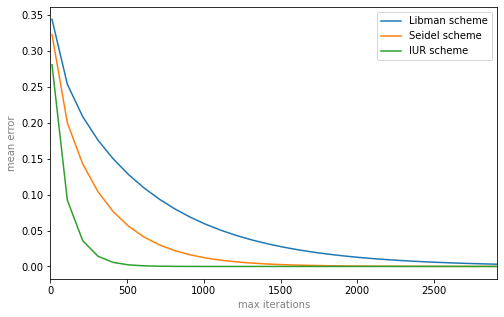

In [198]:
pylab.figure(figsize = (8,5))
pylab.xlabel("max iterations",color = "grey")
pylab.ylabel("mean error",color = "grey")
pylab.xlim(0,np.max(arr[:,0]))
pylab.plot(arr[:,0],arr[:,1],label = "Libman scheme")
pylab.plot(arr[:,0],arr[:,2],label = "Seidel scheme")
pylab.plot(arr[:,0],arr[:,3],label = "IUR scheme")
pylab.legend()
pylab.show()

##### Исследование зависимости ошибки от размера сетки
Все методы проходят по 500 итераций

In [199]:
arr = []
for i in tqdm(range(50,300,50)):
    
    ril_mesh = mesh(i,i,[0,np.pi/2],[0,np.pi/2])
    ril_mesh.set_mesh_values(sol)

    
    lib_mesh = mesh(i,i,[0,np.pi/2],[0,np.pi/2])
    lib_mesh.set_border_val(X0,Xl,Y0,Yl)
    k = lib_mesh.Solve_Libman(2,lim_iteraions = 2000,eps = None)

    lib_error = ril_mesh.compare(lib_mesh)

    Seidel_mesh = mesh(i,i,[0,np.pi/2],[0,np.pi/2])
    Seidel_mesh.set_border_val(X0,Xl,Y0,Yl)
    k = Seidel_mesh.Solve_Seidel(2,lim_iteraions = 2000,eps = None)
    
    Seidel_error = ril_mesh.compare(Seidel_mesh)
    
    IUR_mesh = mesh(i,i,[0,np.pi/2],[0,np.pi/2])
    IUR_mesh.set_border_val(X0,Xl,Y0,Yl)
    k = IUR_mesh.Solve_IUR(2,w = 1.5,lim_iteraions = 2000,eps = None)
    
    IUR_error = ril_mesh.compare(IUR_mesh)
    
    arr.append([i,lib_error,Seidel_error,IUR_error])
        
arr = np.array(arr)

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [36:50<00:00, 442.09s/it]


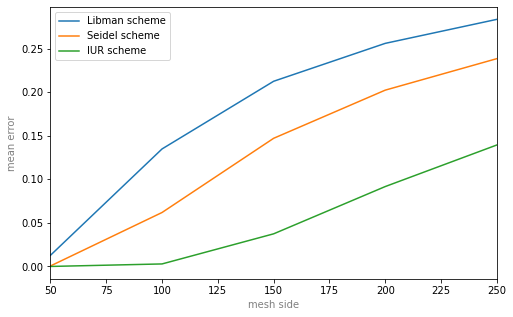

In [201]:
pylab.figure(figsize = (8,5))
pylab.xlabel("mesh side",color = "grey")
pylab.ylabel("mean error",color = "grey")
pylab.xlim(50,np.max(arr[:,0]))
pylab.plot(arr[:,0],arr[:,1],label = "Libman scheme")
pylab.plot(arr[:,0],arr[:,2],label = "Seidel scheme")
pylab.plot(arr[:,0],arr[:,3],label = "IUR scheme")
pylab.legend()
pylab.show()

##### Исследование зависимости скорости сходимости и ошибки от размера сетки

In [202]:
arr = []
for i in tqdm(range(10,100,10)):
    
    ril_mesh = mesh(i,i,[0,np.pi/2],[0,np.pi/2])
    ril_mesh.set_mesh_values(sol)

    
    lib_mesh = mesh(i,i,[0,np.pi/2],[0,np.pi/2])
    lib_mesh.set_border_val(X0,Xl,Y0,Yl)
    k_lib = lib_mesh.Solve_Libman(2,lim_iteraions = 1000)

    lib_error = ril_mesh.compare(lib_mesh)

    Seidel_mesh = mesh(i,i,[0,np.pi/2],[0,np.pi/2])
    Seidel_mesh.set_border_val(X0,Xl,Y0,Yl)
    k_seid = Seidel_mesh.Solve_Seidel(2,lim_iteraions = 1000)
    
    Seidel_error = ril_mesh.compare(Seidel_mesh)
    
    IUR_mesh = mesh(i,i,[0,np.pi/2],[0,np.pi/2])
    IUR_mesh.set_border_val(X0,Xl,Y0,Yl)
    k_iur = IUR_mesh.Solve_IUR(2,w = 1.5,lim_iteraions = 1000)
    
    IUR_error = ril_mesh.compare(IUR_mesh)
    
    arr.append([i,lib_error,Seidel_error,IUR_error,k_lib,k_seid,k_iur])
        
arr = np.array(arr)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [02:56<00:00, 19.66s/it]


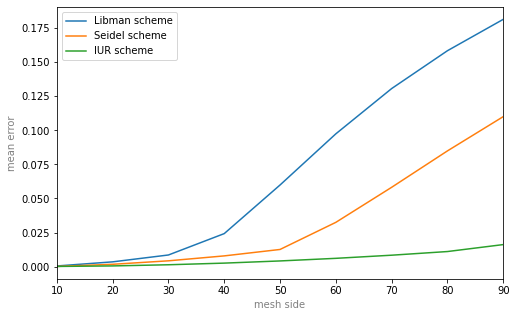

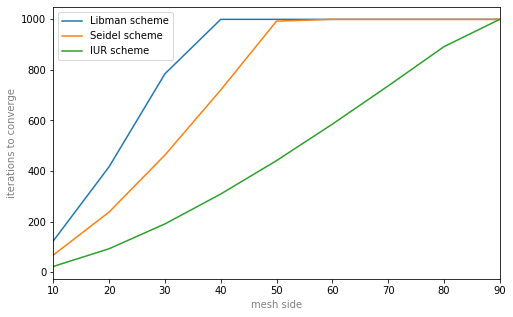

In [203]:
pylab.figure(figsize = (8,5))
pylab.xlabel("mesh side",color = "grey")
pylab.ylabel("mean error",color = "grey")
pylab.xlim(10,np.max(arr[:,0]))
pylab.plot(arr[:,0],arr[:,1],label = "Libman scheme")
pylab.plot(arr[:,0],arr[:,2],label = "Seidel scheme")
pylab.plot(arr[:,0],arr[:,3],label = "IUR scheme")
pylab.legend()
pylab.show()

pylab.figure(figsize = (8,5))
pylab.xlabel("mesh side",color = "grey")
pylab.ylabel("iterations to converge",color = "grey")
pylab.xlim(10,np.max(arr[:,0]))
pylab.plot(arr[:,0],arr[:,4],label = "Libman scheme")
pylab.plot(arr[:,0],arr[:,5],label = "Seidel scheme")
pylab.plot(arr[:,0],arr[:,6],label = "IUR scheme")
pylab.legend()
pylab.show()

##### Исследование метода простой итерации с верхней релаксацией
Зависимость скорости сходимости и ошибки от w

In [184]:
arr = []
for i in tqdm(range(10,100,10)):
    w_cur = 1 + i/100
    
    ril_mesh = mesh(50,50,[0,np.pi/2],[0,np.pi/2])
    ril_mesh.set_mesh_values(sol)
    
    IUR_mesh = mesh(50,50,[0,np.pi/2],[0,np.pi/2])
    IUR_mesh.set_border_val(X0,Xl,Y0,Yl)
    k = IUR_mesh.Solve_IUR(2,w = w_cur,lim_iteraions = 2000)
    
    IUR_error = ril_mesh.compare(IUR_mesh)
    
    arr.append([w_cur,k,IUR_error])
        
arr = np.array(arr)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:27<00:00,  3.05s/it]


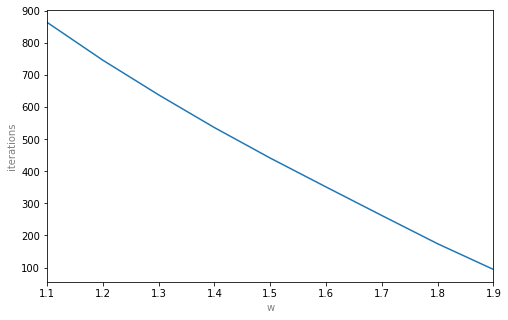

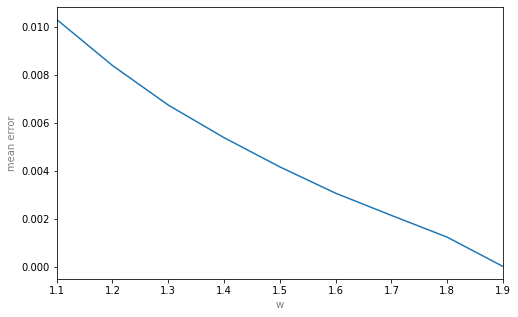

In [186]:
pylab.figure(figsize = (8,5))
pylab.xlabel("w",color = "grey")
pylab.ylabel("iterations",color = "grey")
pylab.xlim(np.min(arr[:,0]),np.max(arr[:,0]))
pylab.plot(arr[:,0],arr[:,1])
pylab.show()

pylab.figure(figsize = (8,5))
pylab.xlabel("w",color = "grey")
pylab.ylabel("mean error",color = "grey")
pylab.xlim(np.min(arr[:,0]),np.max(arr[:,0]))
pylab.plot(arr[:,0],arr[:,2])
pylab.show()

### Вывод

Из графиков зависимости ошибки от числа пройденных итераций видно, что метод Либмана сходится гораздо медленнее, чем метод Зейделя, а метод простой итерации с верхней релаксацией сходится быстрее всего. При исследовании зависимости скорости сходимости и погрешности от размеров сетки выяснилось, что, чем сетка больше, тем больше итераций необходимо, чтобы методы сошлись, а также, на шаге, в который итерационный процесс завершается, (разница между значениями на соседних шагах достаточно мала) ошибка метода тем больше, чем больше узлов в сетке. Метод простой итерации с верхней релаксацией страдает от вышеперечисленных проблем сщественно меньше других. В ходе исследования метода простой итерации с верхней релаксацией выяснилось, что метод сходится тем быстрее, чем ближе w к 2, погршеность при этом также уменьшается. Помимо этого, с приближением значений w к 2, на карте ошибок начинают проступать странные узоры. Если w >= 2, то метод перестает сходиться.